#### THIS NOTEBOOK BUILDS ON PREVIOUS WORK IN `exploring-mpii.ipynb`

In [1]:
import random
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import json
import os
import cv2
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import mixed_precision
from data.H5DataGenerator import H5DataGenerator

C:\Users\willi\anaconda3\envs\tf_gpu\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
coco_folder = "coco"
image_folder_train = os.path.join(coco_folder, "images", "train2017")
image_folder_val = os.path.join(coco_folder, "images", "val2017")

In [3]:
# optional for gpus with lower vram
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [4]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preparing the data
Compared to the MPII dataset, the COCO dataset is quite different, for many reasons. It is a large-scale object detection, segmentation, and captioning dataset. We will use it for pose estimation. The dataset also comes with its own tools, meaning we will not need to work with a painful MATLAB file like we did with the MPII dataset.

But first and foremost, let's check out how many joints are available in the annotations.


In [75]:
coco_train = json.load(open(os.path.join(coco_folder,'person_keypoints_train2017.json')))

In [77]:
i = 0
y = 0
for anno in coco_train['annotations']:
    if anno['num_keypoints'] == 17: i += 1
    if anno['num_keypoints'] == 0: y += 1

print("{} poses has all 17 joints out of {} total. There are {} poses with 0 joints.".format(i, len(coco_train['annotations']), y))

8475 poses has all 17 joints out of 262465 total. There are 112652 poses with 0 joints.


As we can see there are very few annotations with all 17 joints, meaning we can't just skip the ones that don't have all 17 joints. Another problem is the other end of the spectrum where we have over 100k poses with 0 joints, so we should skip these as well, but we should probably limit it to poses with at least 3 joints.

While we are on the topic of removing stuff, why don't we also remove joints that are not interesting to us? The COCO dataset includes 5 joints on the head: nose, left and right eye, and left and right ear. These joints are not interesting to us for this project at least, so we can skip them! (this will also free up memory and time used training the model)

### Create some JSONs
As mentioned above, COCO provides tools for its dataset, by the `pycocotools` library, so we will use this instead of doing it manually.

In [70]:
from pycocotools.coco import COCO

In [483]:
def create_json(coco_json, target_file):
    
    coco = COCO(coco_json)
    
    data = []
    
    cat_ids = coco.getCatIds(catNms=['person'])
    img_ids = coco.getImgIds(catIds=cat_ids)
    
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_name = img_info['file_name']
        
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        
        for ann in anns:
            if "keypoints" not in ann or ann["num_keypoints"] == 0:
                continue
            
            keypoints = ann["keypoints"]
            joint_coords = {}
            visible_joints = {}
            
            for i in range(5,17): # skip the first 5 joints (head joints)
                x = keypoints[i * 3]
                y = keypoints[i * 3 + 1]
                v = keypoints[i * 3 + 2]
                joint_coords[str(i - 5)] = [x, y]
                visible_joints[str(i - 5)] = str(int(v > 0))
            
            if sum(1 for v in visible_joints.values() if v == "1") < 3:
                continue
            
            data.append({
                "filename": img_name,
                "joint_coords": joint_coords,
                "visible_joints": visible_joints,
                "approx_loc": {
                    "scale": max(ann["bbox"][2], ann["bbox"][3]) / 200.0, # same as MPII
                    "x": ann["bbox"][0] + ann["bbox"][2] / 2,
                    "y": ann["bbox"][1] + ann["bbox"][3] / 2,
                }
            })
    
    with open(target_file, 'w') as f:
        json.dump(data, f, indent=2)
        print('JSON was successfully saved!')

In [485]:
create_json(
    coco_json=os.path.join(coco_folder,'person_keypoints_train2017.json'),
    target_file=os.path.join(coco_folder,'data_train.json'),
)

loading annotations into memory...
Done (t=6.88s)
creating index...
index created!
JSON was successfully saved!


In [484]:
create_json(
    coco_json=os.path.join(coco_folder,'person_keypoints_val2017.json'),
    target_file=os.path.join(coco_folder,'data_val.json'),
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
JSON was successfully saved!


## Checkout the data
Let's show a random image and overlay the joints

In [486]:
data_train = json.load(open(os.path.join(coco_folder,'data_train.json')))

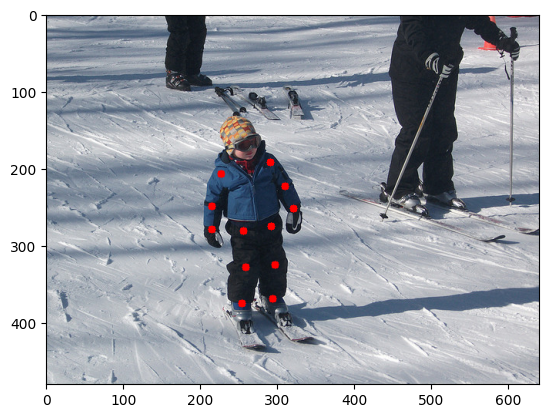

In [487]:
def plot_joints(image_path, coordinates):
    image = cv2.imread(image_path)
    for joint in coordinates:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

example = data_train[13501]
img_filename = example.get('filename')
joints = example.get('joint_coords')

joint_coords = []
for joint, coords in joints.items():
    joint_coords.append((coords[0], coords[1]))

plot_joints(os.path.join(image_folder_train,img_filename), joint_coords)

## Preprocessing the data
We will have to resize and crop the images to the same size, we will also save this into a HDF5 file as it handles large amounts of data very well.

A major change we made since working on the MPII dataset are the shapes, instead of an image being 128x128, it is now 256x256. As well as this we realized that there is no real reason to have the heatmaps the same size, and after looking around the internet it was clear that heatmaps at a quarter of the image size was plenty.

For the MPII dataset we used a `generate_heatmap()` function by ChatGPT, which was ok, but since we now have 64x64 images, we need it to be more precise since we are scaling it up before training. As this kind of mathematics is very dank, we decided to ask ChatGPT this time as well (to save some precious time). We have of course changed some of the code, as ChatGPT rarely produces something that JUST works. As I am about to mention, we did some research to OpenCV and also found that `.circle()` and `.GaussianBlur()` could calculate these gaussian heatmaps, but it is not as accurate as making a custom one.

We also made a custom function for padding the image if needed, but after researching OpenCV further we found `cv2.copyMakeBorder()` which does this for us, so we will just use this instead.

In [5]:
data_train = json.load(open(os.path.join(coco_folder,'data_train.json')))
data_val = json.load(open(os.path.join(coco_folder,'data_val.json')))

In [6]:
def preprocess_image(img_path, objpos, scale, img_size=(256, 256)):
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    crop_size = int(scale * 200)
    x1, y1 = int(objpos[0] - crop_size // 2), int(objpos[1] - crop_size // 2)
    x2, y2 = x1 + crop_size, y1 + crop_size

    pad_top = max(0, -y1)
    pad_left = max(0, -x1)
    pad_bottom = max(0, y2 - h)
    pad_right = max(0, x2 - w)

    x1_clipped = max(0, x1)
    y1_clipped = max(0, y1)
    x2_clipped = min(w, x2)
    y2_clipped = min(h, y2)

    crop = img[y1_clipped:y2_clipped, x1_clipped:x2_clipped]
    crop = cv2.copyMakeBorder(
        crop, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    resized_img = cv2.resize(crop, img_size)
    scale_factor = img_size[0] / crop.shape[1]
    transform_params = (x1,y1,scale_factor)

    return resized_img, transform_params

def adjust_keypoints(keypoints, transform_params):
    x1, y1, scale_factor = transform_params
    adjusted_keypoints = np.zeros((len(keypoints),2), np.float32)
    
    for key, (x, y) in keypoints.items():
        if x == 0 and y == 0: 
            # keep invisible joints at 0,0
            adjusted_keypoints[int(key)] = [0,0]
            continue
        x_new = (x - x1) * scale_factor
        y_new = (y - y1) * scale_factor
        adjusted_keypoints[int(key)] = [x_new, y_new]
    
    return adjusted_keypoints

def generate_heatmap(joint_coords, visible_joints, image_size=(256,256), heatmap_size=(64, 64), sigma=2): # Inspiration from ChatGPT
    num_joints = len(joint_coords)
    heatmaps = np.zeros((heatmap_size[1], heatmap_size[0], num_joints), dtype=np.float32)
    tmp_size = sigma * 3

    for j in range(num_joints):
        if str(j) not in visible_joints or int(visible_joints[str(j)]) == 0: continue

        # Original image coords
        x, y = joint_coords[j]
        if x < 0 or y < 0:
            continue

        # Scale to heatmap size
        x = x * heatmap_size[0] / image_size[0]
        y = y * heatmap_size[1] / image_size[1]

        # Gaussian bounds
        ul = [int(x - tmp_size), int(y - tmp_size)]
        br = [int(x + tmp_size + 1), int(y + tmp_size + 1)]

        # Skip if it's out of bounds
        if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] or br[0] < 0 or br[1] < 0:
            continue

        # Generate Gaussian
        size = 2 * tmp_size + 1
        g = np.exp(-((np.arange(size)[:, None] - tmp_size) ** 2 + (np.arange(size)[None, :] - tmp_size) ** 2) / (2 * sigma ** 2))

        # Determine where to place the Gaussian
        g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
        img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
        img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

        heatmaps[img_y[0]:img_y[1], img_x[0]:img_x[1], j] = np.maximum(
            heatmaps[img_y[0]:img_y[1], img_x[0]:img_x[1], j],
            g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
        )

    return heatmaps

### Test the functions
Let's test out the functions by plotting the outputs over the original image 

In [82]:
def overlay_heatmaps_and_joints(image, joints, visible_joints, alpha=0.4, sigma=2):
    image_size = (image.shape[0], image.shape[1])
    heatmap_size = (image.shape[1] // 4, image.shape[0] // 4)
    
    heatmaps = generate_heatmap(joints, visible_joints, image_size, heatmap_size, sigma)
    
    heatmaps_resized = np.zeros((image.shape[0], image.shape[1], heatmaps.shape[-1]), dtype=np.float32)
    for i in range(heatmaps.shape[-1]):
        heatmaps_resized[:, :, i] = cv2.resize(heatmaps[:, :, i], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    
    combined_heatmap = np.sum(heatmaps_resized, axis=-1)
    combined_heatmap = np.clip(combined_heatmap, 0, 1) # some heatmaps might overlay each other and cause the sum to be higher than 1
    
    plt.figure(figsize=(6, 6))
    for joint in joints:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 3, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(combined_heatmap, cmap="jet", alpha=alpha)
    plt.axis('off')
    plt.show()

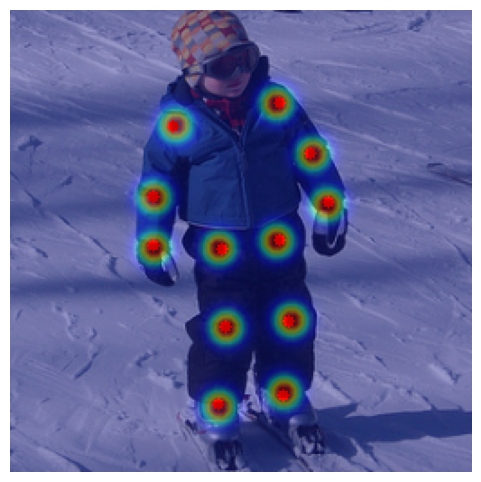

In [92]:
ann = data_train[13501]

preprocessed_img, transform_params = preprocess_image(
    os.path.join(image_folder_train, ann['filename']), 
    (ann['approx_loc']['x'], ann['approx_loc']['y']), 
    ann['approx_loc']['scale'])

joint_coords = ann['joint_coords']
visible_joints = ann['visible_joints']
adjusted_joints = adjust_keypoints(joint_coords, transform_params)

overlay_heatmaps_and_joints(preprocessed_img, adjusted_joints, visible_joints, sigma=1.5)

## Create and save some datasets
Seeing that the functions are working, we can now put this all in a dataset file.

Some major changes from MPII, is that `adjust_keypoints()` does not expect normalized values anymore, and we store the heatmaps as float32 as we didn't see a reason for it anymore as this was mostly done to create the smallest possible file so that it could be loaded into memory all at once, but we don't want this here. We will get back to this in a short bit!

In [7]:
def create_dataset(dataset, name, image_folder):
    num_samples = len(dataset)
    
    with h5py.File(os.path.join(coco_folder,name + '.h5'), 'w') as f:
        img_dataset = f.create_dataset("images", (num_samples, 256, 256, 3), dtype='uint8')
        heatmaps_dataset = f.create_dataset("heatmaps", (num_samples, 64, 64, 12), dtype='float32')
        
        index = 0
        for ann in dataset:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            img_dataset[index] = preprocessed_img
            
            adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params)
            visible_joints = ann['visible_joints']
            heatmaps_dataset[index] = (generate_heatmap(adjusted_keypoints, visible_joints, (256, 256), (64, 64), sigma=1.5) * 255)
            
            index += 1
    
    print(name + ".h5 successfully created")

create_dataset(data_train, 'train_dataset', image_folder_train)
create_dataset(data_val, 'val_dataset', image_folder_val)

train_dataset.h5 successfully created
val_dataset.h5 successfully created


## Building a model
We are going to use some of the models we built for the MPII dataset here as well.

### Loading the datasets
We would like to load the model like we did in MPII, but the problem now is that the file size is too large, and ends up being around 50GB when loading it all using `h5py.File()` directly, so we will have to think a little different about it. The problem as I just said is that we can't load it in all at once, but we don't need to, as we can load it in with batches. The `keras.utils.Sequence` class (now `keras.utils.PyDataset`) will do exactly this, so we have implemented this class as `H5DataGenerator.py`.

In [4]:
train_gen = H5DataGenerator(os.path.join(coco_folder, 'train_dataset.h5'), batch_size=8, data_augmentation=True, flip_indices={
    0: 1,
    2: 3,
    4: 5,
    6: 7,
    8: 9,
    10: 11
})
val_gen = H5DataGenerator(os.path.join(coco_folder, 'val_dataset.h5'), batch_size=8)

### A more complicated model
The model below will predict a heatmap for every joint

In [34]:
def basic_block(input_tensor, filters, strides=1, dilation_rate=2):
    shortcut = input_tensor
    x = layers.Conv2D(filters, (3,3), strides=strides, padding='same', use_bias=False, dilation_rate=dilation_rate)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False, dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), strides=strides, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    out = layers.ReLU()(x)
    return out

def make_layer(x, block, filters, blocks):
    for _ in range(blocks):
        x = block(x, filters)
    return x

def build_heatmap_model(input_shape=(256,256,3), num_joints=12):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = make_layer(x, basic_block, 64, 2)
    x = make_layer(x, basic_block, 128, 2)
    x = make_layer(x, basic_block, 128, 2)
    
    x = layers.MaxPool2D(2)(x)
    
    output = layers.Conv2D(num_joints, (1,1), padding='same', activation="sigmoid")(x)
    return keras.Model(inputs, output, name="Heatmap_Detection")

### A Stacked Hourglass Network model
Stacked hourglass networks has proven to be effective for human pose estimation. This architecture has given state-of-the-art results on the MPII dataset and has outcompeted all recent methods.

https://paperswithcode.com/paper/stacked-hourglass-networks-for-human-pose

It is based on this model: https://github.com/ethanyanjiali/deep-vision/blob/master/Hourglass/tensorflow/hourglass104.py. The reason why we haven't built or even tried to build our own is because we had a feeling that our local GPU couldn't handle a stacked hourglass model, and we were right, but we wanted to try it anyway :)

In [35]:
def bottleneck_block(x, filters, downsample=False):
    skip = x
    if downsample:
        skip = layers.Conv2D(filters, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(skip)
    
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters // 2, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(x)
    
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters // 2, (3,3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(x)
    
    x = layers.Add()([x, skip])
    return x

def hourglass_module(x, filters, depth):
    up = bottleneck_block(x, filters)
    up = bottleneck_block(up, filters)
    
    low = layers.MaxPooling2D((2,2), strides=2)(x)
    low = bottleneck_block(low, filters)
    
    if depth > 1:
        low = hourglass_module(low, filters, depth - 1)
    else:
        low = bottleneck_block(low, filters)
    
    low = bottleneck_block(low, filters)
    up2 = layers.UpSampling2D((2,2))(low)
    
    return up + up2

def build_stacked_hourglass(input_shape=(256,256,3), num_joints=12, stack=4):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = bottleneck_block(x, 128, downsample=True)
    x = layers.MaxPooling2D((2,2), strides=2)(x)
    x = bottleneck_block(x, 128, downsample=False)
    x = bottleneck_block(x, 256, downsample=True)
    
    outputs = []
    for i in range(stack):
        hg = hourglass_module(x, 256, depth=4)
        hg = bottleneck_block(hg, 256)
        
        hg = layers.Conv2D(256, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(hg)
        hg = layers.BatchNormalization(momentum=0.9)(hg)
        hg = layers.ReLU()(hg)
        
        if hg.shape[1] == 64: hg = layers.UpSampling2D(size=(2,2), interpolation="bilinear")(hg)
        out = layers.Conv2D(num_joints, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(hg)
        outputs.append(out)
        
        # adding the prediction back for next module
        x = layers.Conv2D(256, (1,1), strides=1)(hg)
        x = layers.Conv2D(256, (1,1), strides=1)(out)
        x = layers.Add()([x, hg])
    
    return keras.Model(inputs, outputs, name="StackedHourglass_Detection")

### Create a model with a pretrained model
Let's try out the MobileNetV2 model as the backbone of our model

https://keras.io/examples/vision/keypoint_detection/

In [5]:
def build_pretrained_model(input_shape=(256,256,3), num_joints=12):
    inputs = layers.Input(shape=input_shape)
    
    base_model = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs,
    )
    
    x = base_model.output
    
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Conv2D(num_joints, (1,1), padding='same', activation='sigmoid')(x)
    
    return keras.Model(base_model.input, outputs, name="ResNet50-Base_Detection")

### Compile and fit
An important part about training is the hyperparameters, and some of the most important ones are optimization algorithm, learning rate, loss function, and epochs.

#### Custom loss functions
One very important part about training is having a loss function that works well for the use case, and it's always tricky to find the right one. Underneath, there are two functions which are generated by ChatGPT because creating these ourselves is not our strong suit to say the least. The last one; `masked_weighted_huber_loss()`, is a combination between the others which we made ourselves.

In [6]:
# Loss functions generated by ChatGPT

def masked_weighted_heatmap_loss(y_true, y_pred): # MSE-based 
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Foreground weighting: pixels > 0 get extra weight
    weights = tf.where(y_true > 0, 81.0, 1.0)

    # Mask out entire joints that are not visible (heatmap completely 0)
    joint_mask = tf.reduce_sum(y_true, axis=[1, 2], keepdims=True)  # shape (B, 1, 1, J)
    joint_mask = tf.cast(joint_mask > 0, tf.float32)

    # Compute weighted MSE
    squared_error = tf.square(y_true - y_pred)
    loss = squared_error * weights * joint_mask

    # Mean over batch
    return tf.reduce_mean(loss)

def masked_huber_loss(y_true, y_pred): # Custom Huber function
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    error = tf.abs(y_true - y_pred)
    delta = 0.05  # adjust based on how sharp your heatmaps are
    quadratic = tf.minimum(error, delta)
    linear = error - quadratic
    loss = 0.5 * tf.square(quadratic) + delta * linear

    # Only compute loss where ground truth is non-zero (visible joint heatmaps)
    mask = tf.cast(tf.greater(tf.reduce_max(y_true, axis=[1, 2], keepdims=True), 0), tf.float32)
    loss = loss * mask

    return tf.reduce_mean(loss)

def masked_weighted_huber_loss(y_true, y_pred): # Custom Weighted Huber function
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    weights = tf.where(y_true > 0, 10.0, 1.0)
    
    mask = tf.reduce_sum(y_true, axis=[1, 2], keepdims=True)
    mask = tf.cast(mask > 0, tf.float32)
    
    error = tf.abs(y_true - y_pred)
    delta = 0.05
    quadratic = tf.minimum(error, delta)
    linear = error - quadratic
    loss = 0.5 * tf.square(quadratic) + delta * linear

    loss = loss * weights * mask

    return tf.reduce_mean(loss)

In [35]:
model = build_heatmap_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    loss=masked_weighted_huber_loss,
    metrics='mae'
)

model.summary()

Model: "Heatmap_Detection"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 128, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                 

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ModelCheckpoint("coco-best-model.h5", monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ]
)

Epoch 1/25
16686/16686 [==============================] - 1469s 88ms/step - loss: 0.0011 - mae: 0.0086 - val_loss: 0.0010 - val_mae: 0.0064 - lr: 1.0000e-04
Epoch 2/25
16686/16686 [==============================] - 1466s 88ms/step - loss: 0.0010 - mae: 0.0065 - val_loss: 9.6714e-04 - val_mae: 0.0063 - lr: 1.0000e-04
Epoch 3/25
16686/16686 [==============================] - 1455s 87ms/step - loss: 9.6933e-04 - mae: 0.0062 - val_loss: 9.4343e-04 - val_mae: 0.0058 - lr: 1.0000e-04
Epoch 4/25
16686/16686 [==============================] - 1454s 87ms/step - loss: 9.4860e-04 - mae: 0.0060 - val_loss: 9.3039e-04 - val_mae: 0.0058 - lr: 1.0000e-04
Epoch 5/25
16686/16686 [==============================] - 1491s 89ms/step - loss: 9.3389e-04 - mae: 0.0059 - val_loss: 9.1875e-04 - val_mae: 0.0059 - lr: 1.0000e-04
Epoch 6/25
16686/16686 [==============================] - 1453s 87ms/step - loss: 9.2261e-04 - mae: 0.0058 - val_loss: 9.0254e-04 - val_mae: 0.0057 - lr: 1.0000e-04
Epoch 7/25
16686/16686

In [9]:
# We should always save our model
model.save('coco_model_heatmap_lr1e4-huber10_e25-train-val-early-reducelr.keras')
np.save('coco-history-e25.npy', history)

INFO:tensorflow:Assets written to: ram://44d66568-ba87-4649-b798-71c2eb69fe09/assets


INFO:tensorflow:Assets written to: ram://44d66568-ba87-4649-b798-71c2eb69fe09/assets


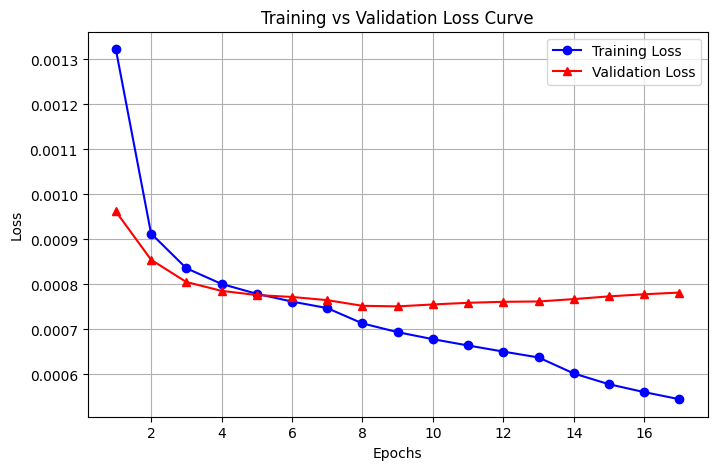

In [10]:
# history = np.load('coco-history-resnet.npy', allow_pickle=True)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' makes blue dots & line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' makes red triangles & line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

## Let's test the model
We will now use the model to predict heatmaps from a random test image, but before then we need to preprocess the test image as well

In [14]:
# Optional, load the model from storage
# load_model doesn't load custom loss functions automatically so if we are just predicting the model we can set compile to False
model = keras.models.load_model('coco-best-model.h5', compile=False) 

In [5]:
data_train = json.load(open(os.path.join(coco_folder,'data_train.json')))
joints_list = json.load(open(os.path.join(coco_folder,'joints.json')))

In [6]:
color_map = ['#0015ff','#00ff1e','#4252ff','#5effaf','#808aff','#b3ffd9','#ffb700','#ff0000','#ffcf54','#ff6161','#ffe49e','#ff9e9e']

def preprocess_test_image(test_image):
    image, _ = preprocess_image(
        os.path.join(image_folder_train, test_image['filename']), 
        (test_image['approx_loc']['x'], test_image['approx_loc']['y']), 
        test_image['approx_loc']['scale']
    )
    
    image = image / 255.0
    return image

def extract_joints(heatmaps, input_res=256, output_res=64):
    coords = []
    for i in range(heatmaps.shape[-1]):
        heatmap = heatmaps[..., i]
        idx = tf.argmax(tf.reshape(heatmap, [-1]), axis=0)
        y, x = tf.unravel_index(idx, (int(output_res), int(output_res)))
        
        coords.append((x.numpy() * (input_res / output_res), y.numpy() * (input_res / output_res)))
    return np.array(coords)

def extract_and_plot_joints(image_rgb, heatmaps):
    extracted_joints = extract_joints(heatmaps)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    
    for i, (x, y) in enumerate(extracted_joints):
        plt.scatter(x, y, c=color_map[i], s=30, label=joints_list[str(i)])
    
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.show()

def show_combined_heatmap(image_rgb, heatmaps):
    if isinstance(heatmaps, tf.Tensor):
        heatmaps = heatmaps.numpy()
  
    heatmaps_resized = np.zeros((image_rgb.shape[0], image_rgb.shape[1], heatmaps.shape[-1]), dtype=np.float32)
    for i in range(heatmaps.shape[-1]):
        heatmap = np.array(heatmaps[..., i], dtype=np.float32)
        heatmaps_resized[..., i] = cv2.resize(heatmap, (image_rgb.shape[1], image_rgb.shape[0]))
    
    combined = np.sum(heatmaps_resized, axis=-1)
    combined = np.clip(combined, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(image_rgb)
    plt.imshow(combined, cmap='jet', alpha=0.6)
    plt.axis('off')
    plt.show()

def show_individual_heatmaps(image_rgb, heatmaps, cols=6):
    if isinstance(heatmaps, tf.Tensor):
        heatmaps = heatmaps.numpy()

    heatmaps_resized = np.zeros((image_rgb.shape[0], image_rgb.shape[1], heatmaps.shape[-1]), dtype=np.float32)
    for i in range(heatmaps.shape[-1]):
        heatmap = np.array(heatmaps[..., i], dtype=np.float32)
        heatmaps_resized[..., i] = cv2.resize(heatmap, (image_rgb.shape[1], image_rgb.shape[0]))
    
    num_joints = heatmaps_resized.shape[-1]
    rows = int(np.ceil(num_joints / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(num_joints):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(image_rgb)
        ax.imshow(heatmaps_resized[:, :, i], cmap='jet', alpha=0.6)
        title = joints_list[str(i)]
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
image = cv2.imread(os.path.join(coco_folder, 'cyclist-3.jpg'))
image = cv2.resize(image, (256, 256)) # just in case it is not
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)

predictions = model.predict(input_image)
heatmaps = tf.squeeze(predictions)

1/1 [==============================] - 0s 17ms/step


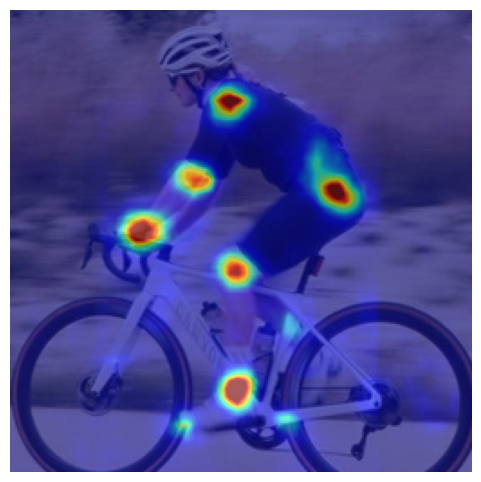

In [24]:
show_combined_heatmap(image_rgb, heatmaps)

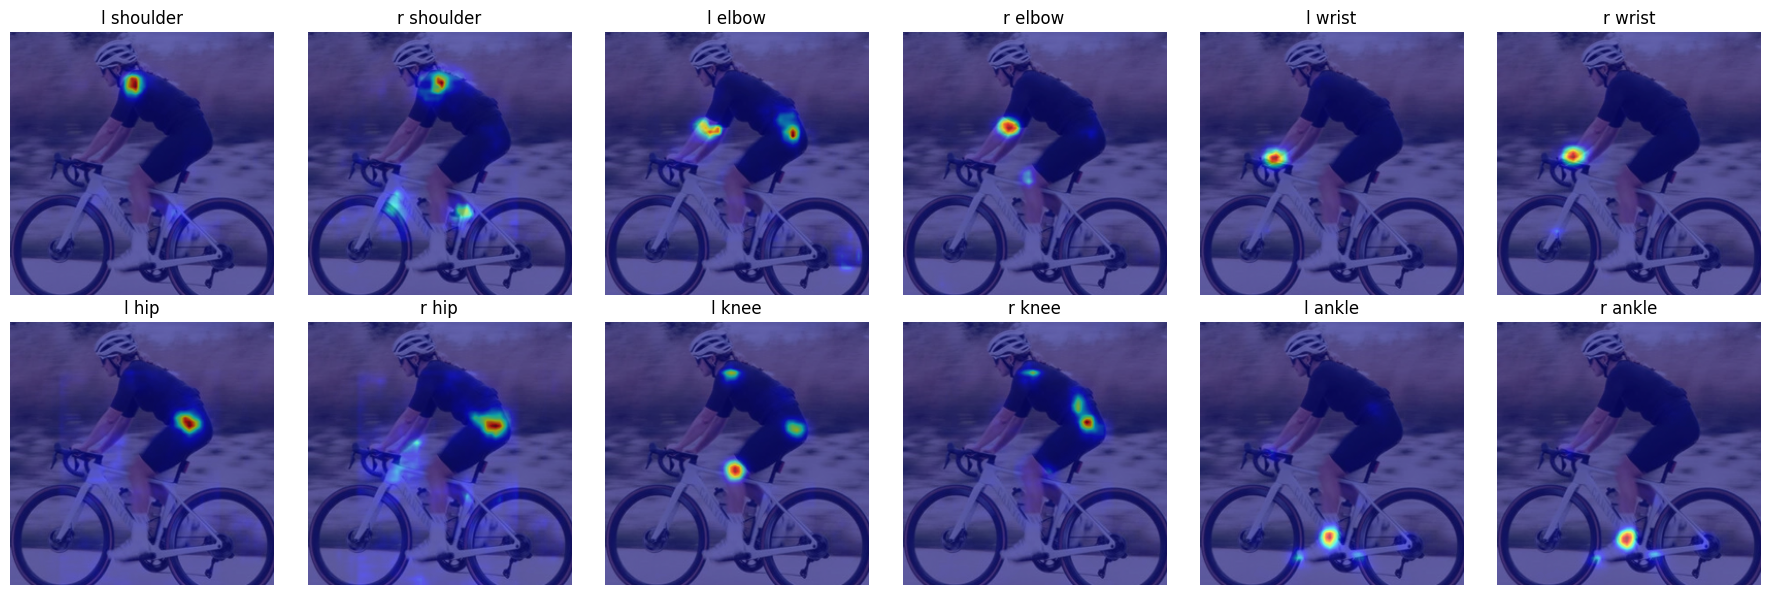

In [25]:
show_individual_heatmaps(image_rgb, heatmaps)

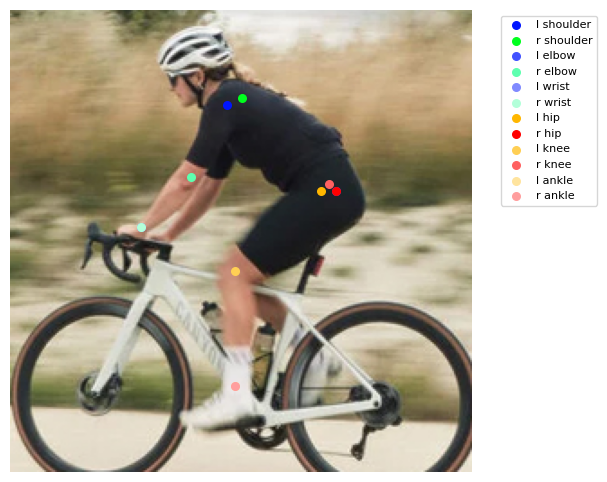

In [26]:
extract_and_plot_joints(image_rgb, heatmaps)

## Compute PCK
PCK (Percentage of Correct Keypoints) is a very common and useful metric when it comes to pose estimation. 

In [20]:
def extract_joints_batch(heatmaps, input_res=256, output_res=64):
    coords = []
    for heatmap in heatmaps:
        extracted_joints = extract_joints(heatmap, input_res, output_res)
        coords.append(extracted_joints)
    return np.array(coords)

def compute_pck(preds, gts, threshold=0.2): # Generated by ChatGPT
    N, num_joints, _ = preds.shape
    assert num_joints == 12, "Expected 12 joints for shoulder–ankle setup."

    dists = np.linalg.norm(preds - gts, axis=2)  # (N, 12)

    # Use torso length (left shoulder index 0 to left hip index 6)
    ref = np.linalg.norm(gts[:, 0] - gts[:, 6], axis=1)  # shape (N,)
    ref = np.where(ref == 0, 1e-6, ref)  # avoid division by zero
    ref = np.expand_dims(ref, axis=1)   # shape (N, 1)

    correct = (dists / ref) <= threshold
    pck_per_joint = np.mean(correct, axis=0)
    pck = np.mean(pck_per_joint)

    return pck, pck_per_joint

In [21]:
val_images, val_heatmaps = val_gen[157]

pred_heatmaps = model.predict(val_images)

pred_coords = extract_joints_batch(pred_heatmaps)
true_coords = extract_joints_batch(val_heatmaps)

pck, pck_per_joint = compute_pck(pred_coords, true_coords)
print("PCK@0.2:", pck)
print("Per-joint:", np.round(pck_per_joint, 3))

1/1 [==============================] - 0s 68ms/step
PCK@0.2: 0.4791666666666667
Per-joint: [0.625 0.5   0.75  0.375 0.75  0.125 0.5   0.5   0.375 0.5   0.25  0.5  ]


# Optimize Model Size

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()
with open("model_basic.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\willi\AppData\Local\Temp\tmp4c240lge\assets


INFO:tensorflow:Assets written to: C:\Users\willi\AppData\Local\Temp\tmp4c240lge\assets
